#### Nome: Rafael Benchimol Klausner

## Motivação

O estudo tem como objetivo estudar a qualidade da recuperação de sinal em um grafo com exemplo os sensores meteorológicos dispostos no Estado do Rio de Janeiro.

O uso dessa metodologia é útil pois é possível estimar o sinal climático de uma determinada região mesmo se tiver falhas em alguns sensores e também é possível extrapolar a informação para determinar índices climáticos sem precisar ter um sensor na região.

## Extração de Dados

Os dados foram coletados pelo site do Instituto Nacional de Meteorologia no endereço https://portal.inmet.gov.br/dadoshistoricos referente ao ano de 2019.

In [1]:
import numpy as np
import scipy.linalg
import scipy.sparse.linalg
from pygsp import graphs, plotting, filters, utils
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import csv
from os import listdir
from os.path import isfile, join
import cvxpy as cp

In [5]:
data_path = "./data/RJ"

In [6]:
onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]

In [7]:
estacoes = []

In [12]:
def extract_data(filepath):
    estacao = {}
    with open(filepath, newline='', encoding='ISO-8859-1') as File:  
        reader = csv.reader(File,delimiter=";")
        read_data = False
        attr = []
        for row in reader:
            if read_data:
                for idx in range(0,len(attr)):
                    if attr[idx] == 'Data' or attr[idx] == 'Hora UTC':
                        estacao[attr[idx]].append(row[idx])
                    else:
                        if row[idx] == "":
                            estacao[attr[idx]].append(0)
                        else:
                            estacao[attr[idx]].append(float(row[idx].replace(",",".")))
            if row[0] == "ESTACAO:":
                estacao[row[0]] = row[1]
            if row[0] == "LATITUDE:":
                estacao[row[0]] = float(row[1].replace(",","."))
            if row[0] == "LONGITUDE:":
                estacao[row[0]] = float(row[1].replace(",","."))
            if row[0] == 'Data':
                attr = row
                read_data = True
                for r in attr:
                    estacao[r] = []
    return estacao,attr

In [13]:
for file in onlyfiles:
    estacao,attr = extract_data(join(data_path,file))
    estacoes.append(estacao)

É possível selecionar qualquer parâmetro de 2 a 18 para ser estudado

In [14]:
for (i,a) in enumerate(attr):
    if i in range(2,19):
        print(str(i)+" "+a)

2 PRECIPITAÇÃO TOTAL, HORÁRIO (mm)
3 PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)
4 PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)
5 PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)
6 RADIACAO GLOBAL (Kj/m²)
7 TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)
8 TEMPERATURA DO PONTO DE ORVALHO (°C)
9 TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)
10 TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)
11 TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)
12 TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)
13 UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)
14 UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)
15 UMIDADE RELATIVA DO AR, HORARIA (%)
16 VENTO, DIREÇÃO HORARIA (gr) (° (gr))
17 VENTO, RAJADA MAXIMA (m/s)
18 VENTO, VELOCIDADE HORARIA (m/s)


In [15]:
attr_chosen = attr[9] # Temperatura

Também pode selecionar qualquer mês para estudo

In [16]:
days_in_month = [31,29,31,30,31,30,31,31,30,31,30,31]

In [17]:
mes_escolhido = 1 # Janeiro
dias_ini = sum(days_in_month[:mes_escolhido-1])
dias_fin = sum(days_in_month[:mes_escolhido])

Se quiser estudar precipitação precisa fazer a soma em vez de média, uma vez que são fornecidos a quantidade de precipitação por hora e não acumulada.

In [18]:
signal = np.array([np.sum(estacao['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'][dias_ini*24:dias_fin*24]) for estacao in estacoes])
coordinates = np.array([[estacao["LATITUDE:"],estacao["LONGITUDE:"]] for estacao in estacoes])

In [19]:
signal = np.array([np.mean(estacao[attr_chosen][dias_ini*24:dias_fin*24]) for estacao in estacoes])
coordinates = np.array([[estacao["LATITUDE:"],estacao["LONGITUDE:"]] for estacao in estacoes])

In [26]:
shapefile = "./gadm36_BRA_shp/gadm36_BRA_0"

### Localização dos sensores

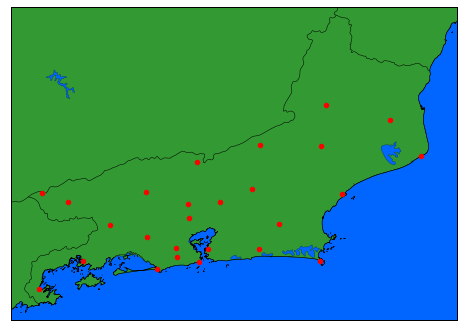

In [29]:
lats = coordinates[:, 0]
lons = coordinates[:, 1]

fig = plt.gcf()
fig.set_size_inches(8, 6.5)

m = Basemap(projection='merc', \
            llcrnrlat=-23.5, urcrnrlat=-20.7, \
            llcrnrlon=-45, urcrnrlon=-40.7, \
            resolution='h')

shp = m.readshapefile(shapefile, 'states', drawbounds=True)
m.drawmapboundary(fill_color='#0066ff')
m.drawstates()
m.fillcontinents(color='#339933',lake_color='#0066ff')
m.drawcoastlines(linewidth=0.2)

x, y = m(lons, lats)  # transform coordinates
plt.scatter(x, y, 20, marker='o', color='Red', zorder=3) 

plt.show()

In [30]:
#fig.savefig("sensors_rj.pdf")

## Construindo o Grafo

O grafo foi construído pela técnica k-NN, no qual ele constroí uma aresta entre os $k$ vizinhos mais próximos a um determinado vértice, deixamos $k = 7$.

In [31]:
G = graphs.NNGraph(coordinates, NNtype='knn', k=7,center=False, rescale=False, symmetrize_type='maximum')
print(f'{G.N} nodes, {G.Ne} edges')

26 nodes, 116 edges


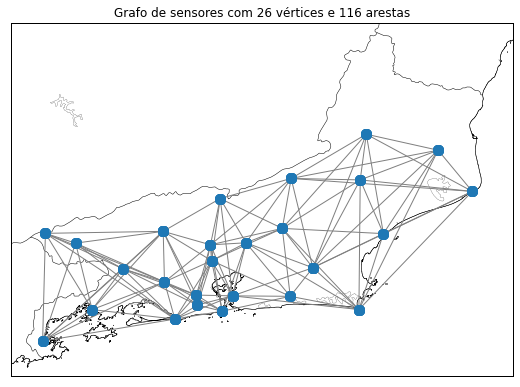

In [32]:
# make up some data for scatter plot
lats = coordinates[:, 0]
lons = coordinates[:, 1]

fig, ax = plt.subplots(1)
fig.set_size_inches(11, 6.5)

m = Basemap(projection='merc', \
            llcrnrlat=-23.5, urcrnrlat=-20.7, \
            llcrnrlon=-45, urcrnrlon=-40.7, \
            resolution='h')
shp = m.readshapefile(shapefile, 'states', drawbounds=True)
m.drawmapboundary(fill_color='white')
m.drawstates()
m.fillcontinents(color='white',lake_color='white')
m.drawcoastlines(linewidth=0.2)
x, y = m(lons, lats)

G.set_coordinates(np.transpose([x,y]))
G.plot(ax=ax)
ax.set_title("Grafo de sensores com "+str(G.N)+" vértices e " + str(G.Ne) + " arestas");

In [28]:
#fig.savefig("sensors_rj_graph.pdf")

## Aplicação do sinal - Temperatura

Podemos definir uma função $f \in \mathcal{F}$ em um grafo como uma função discreta que mapea o conjunto de vértices em um vetor em $\mathbb{C}^N$, onde $|\mathcal{V}| = N$. Com isso, podemos definir o operador Laplaciano $L: \mathcal{F} \to \mathcal{F}$ como
 $L = D - A$.

Podemos perceber que a matriz $L$ é simétrica, assim, é válido o teorema espectral. Logo, existe uma matriz $U$ composta pelos autovetores de $L$ e uma matriz $D$ que é diagonal composta pelos autovalores de $L$ tais que $L = UDU^T$.

Também, podemos definir a transformada de Fourier em Grafos como

\begin{align*}
 \widehat{}: \mathcal{F} \rightarrow \mathbb{R}^{n} && f \mapsto \widehat{f}=U^{t} f
\end{align*}

Além disso, a forma quadrática Laplaciana $S_2: \mathcal{F} \to \mathbb{R} \mid S_2(f) = \langle f, Lf \rangle$ mede o tamanho da função $f$ definida no grafo.

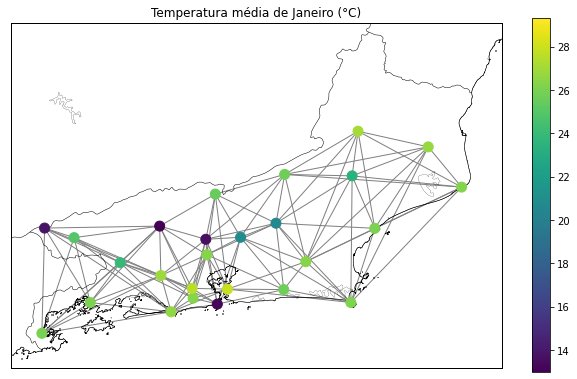

In [33]:
# make up some data for scatter plot
lats = coordinates[:, 0]
lons = coordinates[:, 1]

fig, ax = plt.subplots(1)
fig.set_size_inches(11, 6.5)

m = Basemap(projection='merc', \
            llcrnrlat=-23.5, urcrnrlat=-20.7, \
            llcrnrlon=-45, urcrnrlon=-40.7, \
            resolution='h')
shp = m.readshapefile(shapefile, 'states', drawbounds=True)
m.drawmapboundary(fill_color='white')
m.drawstates()
m.fillcontinents(color='white',lake_color='white')
m.drawcoastlines(linewidth=0.2)
x, y = m(lons, lats)

G.set_coordinates(np.transpose([x,y]))
G.plot_signal(signal,ax=ax)
ax.set_title("Temperatura média de Janeiro (°C)");

In [34]:
#fig.savefig("sensors_rj_graph_temp.pdf")

## Amostragem e reconstrução de sinais

### Limitação de faixa

Seja $\widehat{x}$ a GFT do sinal $x$. Tomando $\mathscr{F}$ como um subconjunto de índices de $\{0,1,\dots, N-1\}$, o sinal $x$ é dito $\mathscr{F}$-esparso se os elementos $\widehat{x}$ com índices $\overline{\mathscr{F}} \triangleq\{0,1, \ldots, N-1\} \backslash \mathscr{F}$ são nulos.

Seja $L = UDU^T$, temos que $x = U\widehat{x}$, e consequentemente, $x_\mathscr{F} = U_\mathscr{F}\check{x}$, onde $U_\mathscr{F}$ corresponde a matriz de autovetores indexados por $F$.

A amostragem corresponde na observação de valores de um sinal no cojunto $\mathscr{D} \subseteq \mathcal{V}$. Assim, podemos montar uma matriz diagonal $D_{\mathscr{D}}$ com entradas $d_i = 1$ se $v_i \in \mathscr{D}$ e $d_i = 0$ caso contrário. Com isso, construímos o vetor $x_{\mathscr{D}} = D_{\mathscr{D}} x$

### Seleção do conjunto de amostragem

#### Aleatória

Podemos pegar vértices aleatórios para amostragem

In [35]:
def rand_bin_array(rs, K, N):
    M = rs.rand(G.N)
    M = (M > 0.1).astype(float)
    return M

In [36]:
def rand_bin_array(rs, K, N):
    arr = np.zeros(N)
    arr[:K]  = 1
    rs.shuffle(arr)
    return arr

In [37]:
def build_subsample(signal, samples):
    rs = np.random.RandomState(1)
    M = rand_bin_array(rs, samples, G.N)
    subsampled_signal = M * signal
    return subsampled_signal,M

In [38]:
subsampled_signal,M = build_subsample(signal,21)

#### Seleção Gulosa

A modelagem mais adequada para o sinal é $x_{w}[k]=x[k]+w[k]$, onde $x_{w}[k]$ é um sinal ruidoso, $x[k]$ é o sinal $\mathscr{F}$-esparso original e $w[k]$ é um ruído. Seja $x_e[k]$ o sinal estimado, assim, podemos calcular o desvio-padrão (SD)

\begin{align*}
\mathrm{SD} &=\left\|x_{\mathrm{e}}[k]-{x}[k]\right\|_{2}^{2} \\ &=\left\|\left(U_{\mathscr{F}}^{T} D_{\mathscr{D}} U_{\mathscr{F}}\right)^{-1} {U}_{\mathscr{F}}^{T} {D}_{\mathscr{D}} {w}[k]\right\|_{2}^{2} 
\end{align*}


Podemos pensar no problema em que não sabemos qual sensor ficará inoperante, assim, é selecionado um conjunto aleatório dos vértices para a reconstrução. Também, podemos pegar um conjunto amostral resultado de uma busca gulosa com o objetivo de maximizar o menor autovalor de $U_{\mathscr{F}}^{T} D_{\mathscr{D}} U_{\mathscr{F}}$.

In [39]:
def selecao_gulosa(G,n_elems):
    N = 15
    D = np.diag(G.d)
    A = G.A.astype(float).toarray()
    L = D - A
    D_final = np.zeros(G.N)
    D = np.zeros(G.N)
    w, v = np.linalg.eig(L)
    U = np.array(v)
    bigcomp = np.argsort(U@signal)[:N]
    U_F = np.array([U[:,i] for i in bigcomp]).T
    ns = []
    
    while(sum(D_final) < n_elems):
        min_eigs = []
        D = D_final.copy()
        for n in range(0,G.N-1):
            D[n] = 1
            D_matrix = np.diag(D)
            a = U_F.T@D_matrix@U_F
            w = scipy.sparse.linalg.eigsh(a, k=1, which='SM', return_eigenvectors=False)
            min_eigs.append(w)
            D[n] = D_final[n]
        d = np.argmax(min_eigs)
        D_final[d] = 1
        ns.append(d)
        
    return D_final,ns

In [40]:
M,ns = selecao_gulosa(G,21)
subsampled_signal = signal * M

### Conjunto de amostrado

O conjunto não amostrado está circulado em amarelo

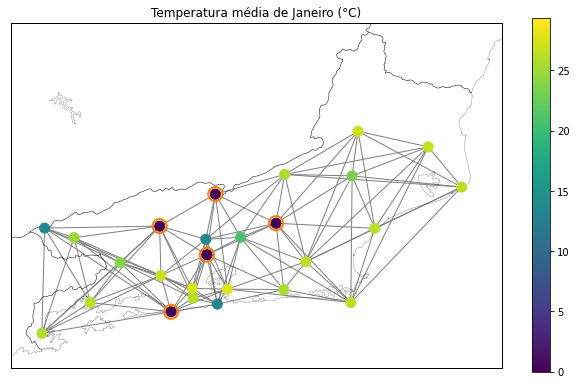

In [41]:
# make up some data for scatter plot
lats = coordinates[:, 0]
lons = coordinates[:, 1]

fig, ax = plt.subplots(1)
fig.set_size_inches(11, 6.5)

m = Basemap(projection='merc', \
            llcrnrlat=-23.5, urcrnrlat=-20.7, \
            llcrnrlon=-45, urcrnrlon=-40.7, \
            resolution='h')

m.drawmapboundary(fill_color='white')
m.drawstates()
m.fillcontinents(color='white',lake_color='white')
m.drawcoastlines(linewidth=0.2)
x, y = m(lons, lats)

G.set_coordinates(np.transpose([x,y]))
G.plot_signal(subsampled_signal,highlight=(1-M).astype(bool),ax=ax)
ax.set_title("Temperatura média de Janeiro (°C)");

In [42]:
#fig.savefig("rj_temp_subsample.pdf")

### Reconstrução do sinal

In [43]:
def erro_sinal(x_e):
    return np.abs(signal-x_e)/signal
def are(x_e):
    return np.linalg.norm(signal-x_e)/np.linalg.norm(signal)

#### Estimativa LMS

A estimativa LMS consiste em resolver o problema de otimização

\begin{equation*}
\min _{\widetilde{x}_{\mathscr{F}}[k]} \mathbb{E}\left\{\left\|{D}_{\mathscr{D}}\left(x_{w}[k]-{U}_{\mathscr{F}} \widehat{x}_{\mathscr{F}}[k]\right)\right\|_{2}^{2}\right\}
\end{equation*}

Utilizando o método de gradiente estocástico, podemos encontrar o próximo iterado $x_e[k+1]$ pela equação:

\begin{equation*}
{x}_{\mathrm{e}}[k+1]={x}_{\mathrm{e}}[k]+\mu {U}_{\mathscr{F}} {U}_{\mathscr{F}}^{T} {D}_{\mathscr{D}}\left({x}_{w}[k]-{x}_{\mathrm{e}}[k]\right)
\end{equation*}

Onde $\mu$ é chamado de tamanho do passo.

In [45]:
def solve_lms(G,M,subsampled_signal):
    N = 15
    D = np.diag(G.d)
    A = G.A.astype(float).toarray()
    L = D - A
    w, v = np.linalg.eig(L)
    D = np.diag(M)
    U = np.array(v)
    bigcomp = np.argsort(U@signal)[:N]
    U_F = np.array([U[:,i] for i in bigcomp]).T
    
    max_iter = 5000
    μ = 1
    x_e = np.zeros(G.N)
    
    for i in range(1,max_iter):
        x_e = x_e + μ*U_F@U_F.T@D@(subsampled_signal-x_e)
    return x_e

#### Estimativa RLS

A estimativa RLS tem o mesmo princípio da LMS, porém o problema de otimização é:

\begin{equation*}
\min _{\tilde{x}_{\mathscr{F}}} \sum_{l=1}^{k} \beta^{k-l}\left\|{D}_{\mathscr{D}}\left({x}_{w}[l]-{U}_{\mathscr{F}} \widehat{{x}}_{\mathscr{F}}\right)\right\|_{{C}_{w}^{-1}}^{2}+\beta^{k}\left\|\widetilde{{x}}_{\mathscr{F}}\right\|_{{\Pi}}^{2}
\end{equation*}

Onde $0 \ll \beta \leq 1$ é um fator de esquecimento e $\Pi$ é uma matriz de regularização, geralmente escolhida como $\Pi = \delta I$, para $\delta > 0$.

Ao resolver o problema, podemos perceber que o sinal $x_{\mathrm{e}}[k]={U}_{\mathscr{F}} {\Psi}^{-1}[k] \psi[k]$, onde $\Psi$ e $\psi$ são calculados por:

\begin{align*}
&{\Psi}[k]=\beta {\Psi}[k-1]+{U}_{\mathscr{F}}^{T} {D}_{\mathscr{D}} {C}_{w}^{-1}[k] {U}_{\mathscr{F}} \\
&\psi[k]=\beta \psi[k-1]+{U}_{\mathscr{F}}^{T} {D}_{\mathscr{D}} {C}_{w}^{-1}[k] {x}_{w}[k]
\end{align*}

Onde ${C}_{w}$ é a matriz de covariância do ruído $w[k]$.

In [46]:
def solve_rls(G,M,subsampled_signal):
    N = 15
    D = np.diag(G.d)
    A = G.A.astype(float).toarray()
    L = D - A
    w, v = np.linalg.eig(L)
    D = np.diag(M)
    U = np.array(v)
    bigcomp = np.argsort(U@signal)[:N]
    U_F = np.array([U[:,i] for i in bigcomp]).T
    β = 0.95
    sigma_1 = np.ones(N)*0.01**2
    sigma_2 = np.ones(int(len(M)))*0.1
    C = np.linalg.inv(np.diag(sigma_2))
    Psi = np.diag(sigma_1)
    psi = np.zeros(N)

    max_iter = 1000
    x_e = np.zeros(G.N)
    
    for i in range(1,max_iter):
        Psi = β*Psi + U_F.T@D@C@U_F
        psi = β*psi + U_F.T@D@C@subsampled_signal
        x_e = U_F@np.linalg.inv(Psi)@psi
    return x_e

#### Minimização da forma quadrática Laplaciana

Podemos construir o problema de otimização

\begin{align*}
&\underset{\mathrm{s} \in \mathbb{R}^{N}}{ \min } \quad S_2(s) = \langle s, Ls \rangle \\ 
&\text { s.a. } \quad \mathrm{D}_{\mathscr{D}} \mathrm{s}=\mathrm{D}_{\mathscr{D}} \mathrm{x}
\end{align*}

Com isso, o ponto ótimo $s^*$ será o sinal mais suave que mantém as amostras intactas. Esse tipo de otimização é chamado de QP (Quadratic Programming)

In [44]:
def solve_quad(G,M,subsampled_signal):
    D = np.diag(G.d)
    A = G.A.astype(float).toarray()
    L = D - A
    D = np.diag(M)

    s = cp.Variable(G.N)
    constraints = [D@s == subsampled_signal]
    prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(s, L)),
                      constraints)
    prob.solve()
    return s.value

#### Comparação entre RLS e LMS

In [47]:
solve_rls(G,M,subsampled_signal) - solve_lms(G,M,subsampled_signal)

array([ 4.87432317e-12,  2.34479103e-13, -6.65956179e-12, -4.08562073e-12,
       -2.56861199e-12, -5.64881475e-13, -1.27897692e-13,  5.65947289e-12,
       -7.42339523e-12,  4.75353090e-12,  7.12674364e-12,  2.06767936e-12,
        6.39488462e-12,  2.02149408e-12,  1.53228541e-11,  3.33244543e-12,
       -4.44089210e-13,  1.61293201e-12,  1.07860387e-11,  7.31770200e-12,
        2.84217094e-12,  9.45021839e-13,  1.05480069e-11,  2.98072678e-12,
        3.33777450e-12, -1.96109795e-12])

Os valores de LMS e RLS são praticamente iguais

## Resultados

### RLS

In [48]:
x_e = solve_rls(G,M,subsampled_signal)

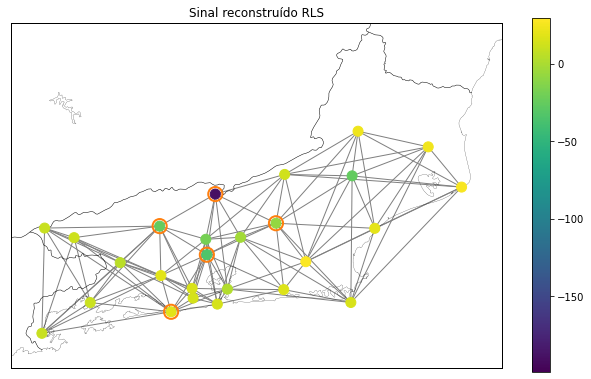

In [49]:
# make up some data for scatter plot
lats = coordinates[:, 0]
lons = coordinates[:, 1]

fig, ax = plt.subplots(1)
fig.set_size_inches(11, 6.5)

m = Basemap(projection='merc', llcrnrlat=-23.5, urcrnrlat=-20.7, llcrnrlon=-45, urcrnrlon=-40.7, resolution='h', ax = ax)

m.drawmapboundary(fill_color='white')
m.drawstates()
m.fillcontinents(color='white',lake_color='white')
m.drawcoastlines(linewidth=0.2)
x, y = m(lons, lats)

G.set_coordinates(np.transpose([x,y]))
G.plot_signal(x_e,highlight=(1-M).astype(bool),ax=ax)
ax.set_title("Sinal reconstruído RLS");

In [50]:
#fig.savefig("rj_temp_rls.pdf")

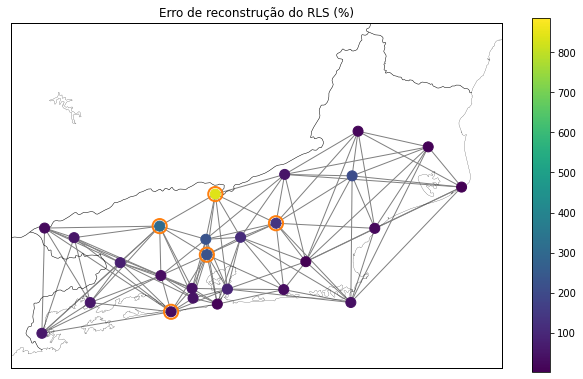

In [51]:
# make up some data for scatter plot
lats = coordinates[:, 0]
lons = coordinates[:, 1]

fig, ax = plt.subplots(1)
fig.set_size_inches(11, 6.5)

m = Basemap(projection='merc', llcrnrlat=-23.5, urcrnrlat=-20.7, llcrnrlon=-45, urcrnrlon=-40.7, resolution='h', ax = ax)

m.drawmapboundary(fill_color='white')
m.drawstates()
m.fillcontinents(color='white',lake_color='white')
m.drawcoastlines(linewidth=0.2)
x, y = m(lons, lats)

G.set_coordinates(np.transpose([x,y]))
G.plot_signal(erro_sinal(x_e)*100,highlight=(1-M).astype(bool),ax=ax)
ax.set_title("Erro de reconstrução do RLS (%)");

In [52]:
#fig.savefig("rj_error_rls.pdf")

### Programação Quadrática

In [53]:
x_e = solve_quad(G,M,subsampled_signal)

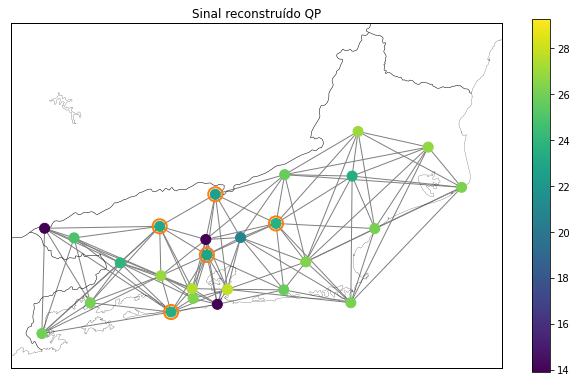

In [54]:
lats = coordinates[:, 0]
lons = coordinates[:, 1]

fig, ax = plt.subplots(1)
fig.set_size_inches(11, 6.5)

m = Basemap(projection='merc', llcrnrlat=-23.5, urcrnrlat=-20.7, llcrnrlon=-45, urcrnrlon=-40.7, resolution='h', ax = ax)

m.drawmapboundary(fill_color='white')
m.drawstates()
m.fillcontinents(color='white',lake_color='white')
m.drawcoastlines(linewidth=0.2)
x, y = m(lons, lats)

G.set_coordinates(np.transpose([x,y]))
G.plot_signal(x_e,highlight=(1-M).astype(bool),ax=ax)
ax.set_title("Sinal reconstruído QP");

In [55]:
#fig.savefig("rj_temp_qp.pdf")

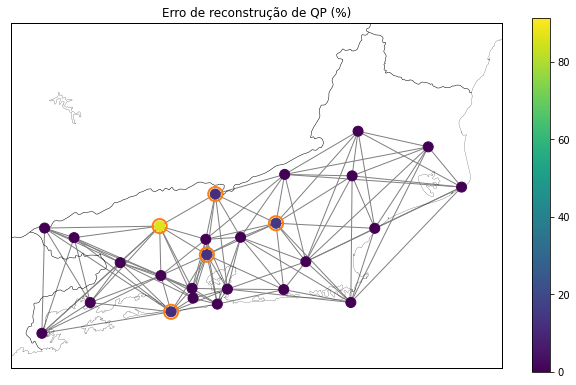

In [56]:
# make up some data for scatter plot
lats = coordinates[:, 0]
lons = coordinates[:, 1]

fig, ax = plt.subplots(1)
fig.set_size_inches(11, 6.5)

m = Basemap(projection='merc', llcrnrlat=-23.5, urcrnrlat=-20.7, llcrnrlon=-45, urcrnrlon=-40.7, resolution='h', ax = ax)

m.drawmapboundary(fill_color='white')
m.drawstates()
m.fillcontinents(color='white',lake_color='white')
m.drawcoastlines(linewidth=0.2)
x, y = m(lons, lats)

G.set_coordinates(np.transpose([x,y]))
G.plot_signal(erro_sinal(x_e)*100,highlight=(1-M).astype(bool),ax=ax)
ax.set_title("Erro de reconstrução de QP (%)");

In [52]:
#fig.savefig("rj_error_quad.pdf")